In [1]:
import pandas as pd
from datetime import datetime
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def open_risk_free_yields():
    df = pd.read_csv('risk_free_yields.csv')
    df["date"] = df.apply(lambda row: datetime.strptime(row["date"], "%Y-%m-%d"), axis=1)
    return df

def open_issuance_data():
    df = pd.read_csv('issuance_data.csv')
    return df

def get_filenames_without_extension_os(directory_path):
    filenames_without_ext = []
    for filename_with_ext in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, filename_with_ext)):
            name, ext = os.path.splitext(filename_with_ext)
            filenames_without_ext.append(name)
    return filenames_without_ext

In [3]:
risk_free_yields = open_risk_free_yields()
issuance_data = open_issuance_data()

In [4]:
files =  get_filenames_without_extension_os('./trade_data')


In [5]:
trades_dict = dict.fromkeys(files, "")
meta_dict = dict.fromkeys(files, "")

In [6]:
def get_risk_free_yield(start_date, to_maturity):
    items = risk_free_yields['date'].to_numpy()
    closest_date = nearest_date(items, start_date)
    periods = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 7.0, 10.0, 15.0]
    closest_period = get_closest_period(to_maturity, periods)
    column_name = get_col_name(closest_period)
    row = risk_free_yields.loc[risk_free_yields['date'] == closest_date]
    return row[column_name].values[0]

def get_col_name(period):
    return 'period_' + str(period)

def get_closest_period(value, periods):
    result = min(periods, key=lambda x: abs(x - value))
    return result

def nearest_date(items, pivot):
    return min([i for i in items if i <= pivot], key=lambda x: abs(x - pivot))

In [7]:
def calculate_ytm(row, coupon):
    face_value = 100
    present_value = row["ohlc4"]
    avg = (face_value + present_value) / 2
    t = row["toMaturity"]
    ytm = (coupon + (face_value - present_value) / t) / avg
    return ytm * 100

In [8]:
def process_trade_data(meta):
    name = meta["Название"].values[0]
    df = pd.read_csv('./trade_data/' + name + '.csv', dtype={'<DATE>': object})
    df["ohlc4"] = ( df["<CLOSE>"] + df["<OPEN>"] + df["<HIGH>"] + df["<LOW>"] ) / 4
    df["date"] = df.apply(lambda row: datetime.strptime(str(row["<DATE>"]), "%d%m%y"), axis=1)
    df["dateEnd"] = df.apply(lambda row: datetime.strptime(meta["dateEnd"].values[0], "%Y-%m-%d"), axis=1)
    df["toMaturity"] = df.apply(lambda row: (row["dateEnd"] - row["date"]).days / 365, axis=1)
    df["risk_free_yield"] = df.apply(lambda row: get_risk_free_yield(row["date"], row["toMaturity"]), axis=1)
    df["ytm"] = df.apply(lambda row: calculate_ytm(row, meta["effYield"]), axis=1)
    df["premium"] = df["ytm"] - df["risk_free_yield"]
    return df


In [9]:
for key in meta_dict.keys():
    meta_dict[key] = issuance_data[ issuance_data["Название"] == key]

In [10]:
for key in trades_dict.keys():
    trades_dict[key] = process_trade_data(meta_dict[key])

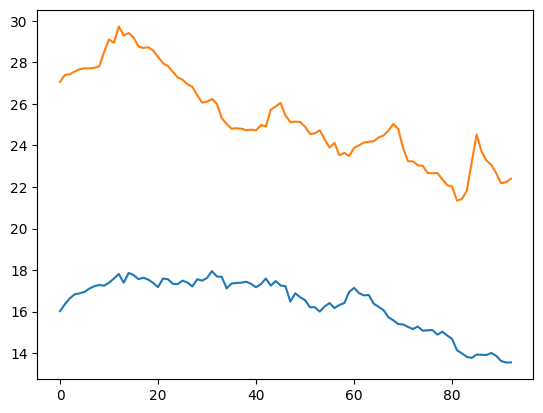

In [11]:
plt.plot(trades_dict["NSKATD-03"]["risk_free_yield"])
plt.plot(trades_dict["NSKATD-03"]["ytm"])

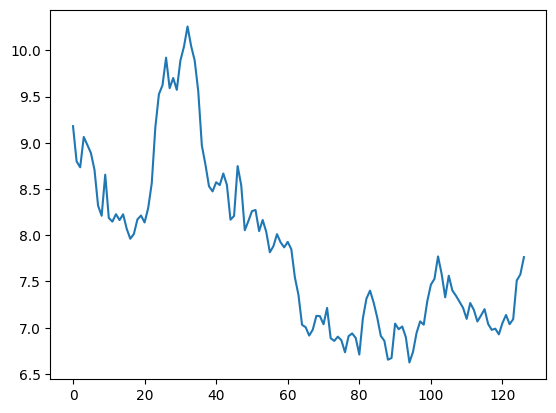

In [12]:
plt.plot(trades_dict['ПАО ЛК Европлан 001P-09']["premium"])

In [13]:
average_premium = np.zeros(30)

In [14]:
for i in range(30):
    premium = 0
    tickers = len(trades_dict)
    for key in trades_dict:
        local_premium = trades_dict[key].iloc[i]["premium"]
        premium += local_premium / tickers
    average_premium[i] = premium

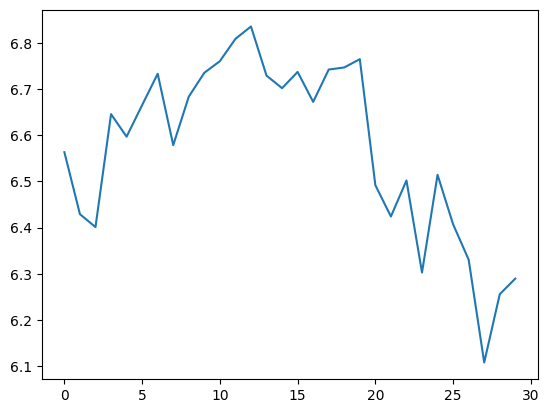

In [70]:
plt.plot(average_premium)

In [17]:
for key in trades_dict.keys():
    starting_premium = trades_dict[key]["premium"].iloc[0]
    trades_dict[key]["relative_premium"] = trades_dict[key]["premium"] / starting_premium

In [ ]:
# Calculating relative average premium
average_relative_premium = np.zeros(30)
for i in range(30):
    premium = 0
    tickers = len(trades_dict)
    for key in trades_dict:
        local_premium = trades_dict[key].iloc[i]["relative_premium"]
        premium += local_premium / tickers
    average_relative_premium[i] = premium

Text(0.5, 1.0, 'Relative Premium Across All Issuance')

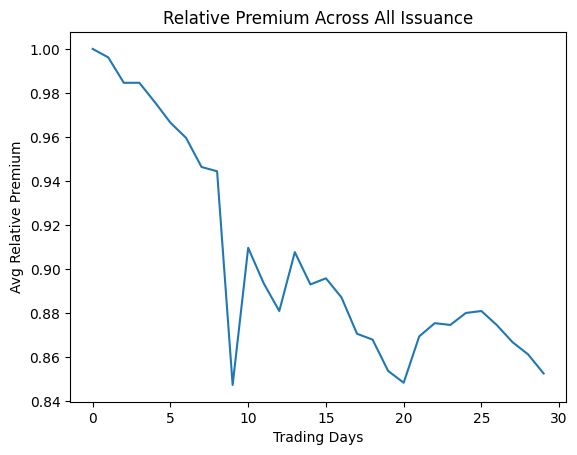

In [26]:
fig, ax = plt.subplots()
ax.plot(average_relative_premium)
ax.set_xlabel("Trading Days")
ax.set_ylabel("Avg Relative Premium")
ax.set_title("Relative Premium Across All Issuance")

In [27]:
ratings = {
    'AA': 1,
    "A": 2,
    "BBB": 3,
    "BB": 4,
    "BB-": 5,
    "B+": 6,
    "B": 7,
}

In [57]:
# Calculating relative average premium
average_relative_premium = np.zeros(30)
for i in range(30):
    premium = 0
    tickers = len(trades_dict)
    num_tickers = 0
    for key in meta_dict:
        if (meta_dict[key]["Объем"].values[0] >1000 and meta_dict[key]["Объем"].values[0] >5000):
            local_premium = trades_dict[key].iloc[i]["relative_premium"]
            premium += local_premium
            num_tickers+=1
    premium/=num_tickers
    average_relative_premium[i] = premium
    print(premium)
    print(num_tickers)

1.0
41
1.0293390155272077
41
0.9957499115816179
41
0.9970278443392177
41
0.9804886134389579
41
0.9643357126068354
41
0.9515370399284842
41
0.9281278625810244
41
0.9340315895741459
41
0.87717597880317
41
0.849646310524883
41
0.8089582858822157
41
0.7783828648026052
41
0.859964431055849
41
0.8266700880442623
41
0.822738535018505
41
0.805525174611525
41
0.8190897352873652
41
0.8124941735455309
41
0.7915891932720364
41
0.7803065419604922
41
0.7602528982677156
41
0.759939056445938
41
0.7268807307029874
41
0.7913650829930856
41
0.7892350988768448
41
0.7766688423044791
41
0.7585308692259469
41
0.7385561214635196
41
0.7316947741784491
41


Text(0.5, 1.0, 'Relative Premium Across Issues >5000')

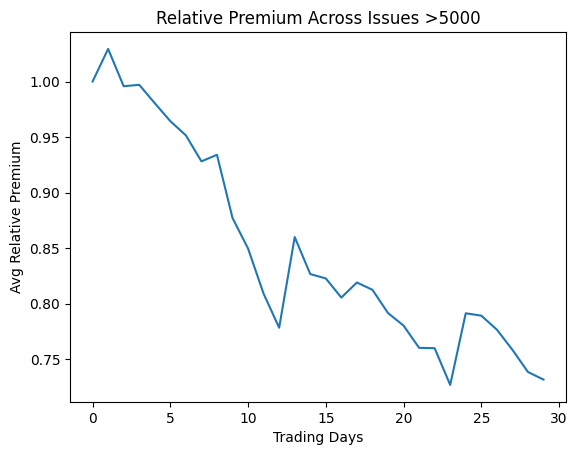

In [58]:
fig, ax = plt.subplots()
ax.plot(average_relative_premium)
ax.set_xlabel("Trading Days")
ax.set_ylabel("Avg Relative Premium")
ax.set_title("Relative Premium Across Issues >5000")

In [85]:
number_of_issues = np.zeros([7, 5])
avg_premium_30d = np.zeros([7, 5])

3

In [87]:
# Calculating relative average premium
for key in meta_dict:
    i = meta_dict[key]["numRating"].values[0] -1
    volume = meta_dict[key]["Объем"].values[0]
    j = datetime.strptime(meta_dict[key]["dateStart"].values[0], "%Y-%m-%d").month -1
    premium = trades_dict[key]["relative_premium"].iloc[29]
    number_of_issues[i, j]+=1
    avg_premium_30d[i, j]+=premium

In [88]:
print(avg_premium_30d/number_of_issues)
print(number_of_issues)

[[0.68145159 0.64814612 0.21178638 1.05314345 0.53033138]
 [1.04277723        nan 0.57662368 0.73880315        nan]
 [       nan 0.90236515 0.79053108 0.80433903 0.86782376]
 [       nan 0.98855348 0.8399708  0.9387497  0.93743581]
 [1.00497965 0.89416663 0.92176852 0.95668456 0.96315518]
 [       nan 1.13438113 0.96455246 0.98724836 1.06921241]
 [1.04841651 1.02984991 0.95276906 0.91791777 0.93951537]]
[[ 4. 14.  5.  4.  4.]
 [ 1.  0.  2.  1.  0.]
 [ 0.  4.  5.  3.  2.]
 [ 0.  5. 11.  8.  2.]
 [ 3.  1.  3.  2.  2.]
 [ 0.  2.  4.  3.  3.]
 [ 2.  8.  8.  5.  3.]]


C:\Users\igorp\AppData\Local\Temp\ipykernel_6560\4155610227.py:1: RuntimeWarning: invalid value encountered in divide
  print(avg_premium_30d/number_of_issues)


In [ ]:
avg_premium_30d /= number_of_issues

C:\Users\igorp\AppData\Local\Temp\ipykernel_6560\2042011141.py:1: RuntimeWarning: invalid value encountered in divide
  avg_premium_30d /= number_of_issues


In [71]:
avg_premium_30d

array([[ 0.79659485, -0.16282841,  0.66863376],
       [        nan,  0.56981625,  0.78833717],
       [        nan,  0.80914491,  0.88569528],
       [ 0.70680729,  0.93962943,  0.87090061],
       [ 0.90874971,  0.94527098,  1.0006501 ],
       [ 1.04636218,  0.98136425,         nan],
       [ 0.99703558,  0.87935222,         nan]])